### IMPORTING THE NECESSARY LIBRARIES

In [61]:
import pandas as pd
import numpy as np

import time

import requests
from bs4 import BeautifulSoup

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

### IMPORTING AND CLEANING THE DATASET
dataset created in /get_all_games.ipynb within the same directory

In [62]:
df = pd.read_csv('allnbagames.csv')

## Converting the points to floats with removing all the rows without a valid value in either points columns

df['PTS'] = pd.to_numeric(df['PTS'], errors = 'coerce')
df['PTS.1'] = pd.to_numeric(df['PTS.1'], errors = 'coerce')
df = df.dropna(subset = ['PTS']).reset_index(drop = True)

## Removing the unnecessary columns

columns_to_drop = df.filter(like = 'Unnamed').columns
df = df.drop(columns = columns_to_drop)

## Renaming the columns for easier usage

df = df.rename(columns = {'Home/Neutral': 'Home', 'Visitor/Neutral': 'Visitor', 'PTS': 'VisPts', 'PTS.1': 'HomePts'})

## Organizing the dataframe columns

df = df[['Date', 'Home', 'HomePts', 'Visitor', 'VisPts', 'Arena', 'Attend.', 'Notes', 'Start (ET)']]

In [63]:
df

,Date,Home,HomePts,Visitor,VisPts,Arena,Attend.,Notes,Start (ET)
0,"Fri, Nov 1, 1946",Toronto Huskies,66.0,New York Knicks,68.0,Maple Leaf Gardens,NaN,NaN,NaN
1,"Sat, Nov 2, 1946",Chicago Stags,63.0,New York Knicks,47.0,Chicago Stadium,NaN,NaN,NaN
2,"Sat, Nov 2, 1946",St. Louis Bombers,56.0,Pittsburgh Ironmen,51.0,St. Louis Arena,NaN,NaN,NaN
3,"Sat, Nov 2, 1946",Detroit Falcons,33.0,Washington Capitols,50.0,Detroit Olympia,NaN,NaN,NaN
4,"Sat, Nov 2, 1946",Providence Steamrollers,59.0,Boston Celtics,53.0,Rhode Island Auditorium,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
70529,"Thu, Jun 6, 2024",Boston Celtics,107.0,Dallas Mavericks,89.0,TD Garden,19156.0,NaN,8:30p
70530,"Sun, Jun 9, 2024",Boston Celtics,105.0,Dallas Mavericks,98.0,TD Garden,19156.0,NaN,8:00p
70531,"Wed, Jun 12, 2024",Dallas Mavericks,99.0,Boston Celtics,106.0,American Airlines Center,20311.0,NaN,8:30p
70532,"Fri, Jun 14, 2024",Dallas Mavericks,122.0,Boston Celtics,84.0,American Airlines Center,20277.0,NaN,8:30p


### CALCULATING THE PERCENTAGE OF  HOME WINS THROUOUGHT THE NBA HISTORY

In [64]:
home_wins = 0

for i, row in df.iterrows():
    home_pts = row['HomePts']
    vis_pts = row['VisPts']

    if home_pts > vis_pts:
        home_wins = home_wins + 1
        
home_wins_perc = round(home_wins / len(df), 3)

print(f"Home win percentage in the NBA history: {home_wins_perc}")

Home win percentage in the NBA history: 0.613


### CALCULATING HOME WINS IN EVERY SINGLE CALENDAR YEAR

In [65]:
## Creating empty lists for years, home_wins, and away_wins, which will eventually end up in a dataframe

years = [year for year in range(1946, 2025)]

home_wins, away_wins = [], []
for year in years:
    home_wins.append(0)
    away_wins.append(0)
    
## Looping through all the dataframe rows and adding wins to either home_wins or away_wins    
    
for i, row in df.iterrows():
    for i in range(len(years)):
        if str(years[i]) in row['Date']:
            home_pts = row['HomePts']
            vis_pts = row['VisPts']
            if home_pts > vis_pts:
                home_wins[i] = home_wins[i] + 1
            else:
                away_wins[i] = away_wins[i] + 1
                
## Combining it all into a dataframe

wins_by_year_df = pd.DataFrame(list(zip(years, home_wins, away_wins)), columns = ['Year', 'HomeW', 'AwayW'])

## Calculating the percentage of home wins

wins_by_year_df['HomePerc'] = round(wins_by_year_df['HomeW'] / (wins_by_year_df['HomeW'] + wins_by_year_df['AwayW']), 3)

## Getting the rolling average of five seasons, and changing the HomePerc column from the mean percentages to the percentage of home wins throuought the five year period

rolling_avg = round(wins_by_year_df.rolling(window = 5).mean(), 3)
rolling_avg['HomePerc'] = round(rolling_avg['HomeW'] / (rolling_avg['HomeW'] + rolling_avg['AwayW']), 3)

### NBA HOME WIN PERCENTAGE VISUALISATION

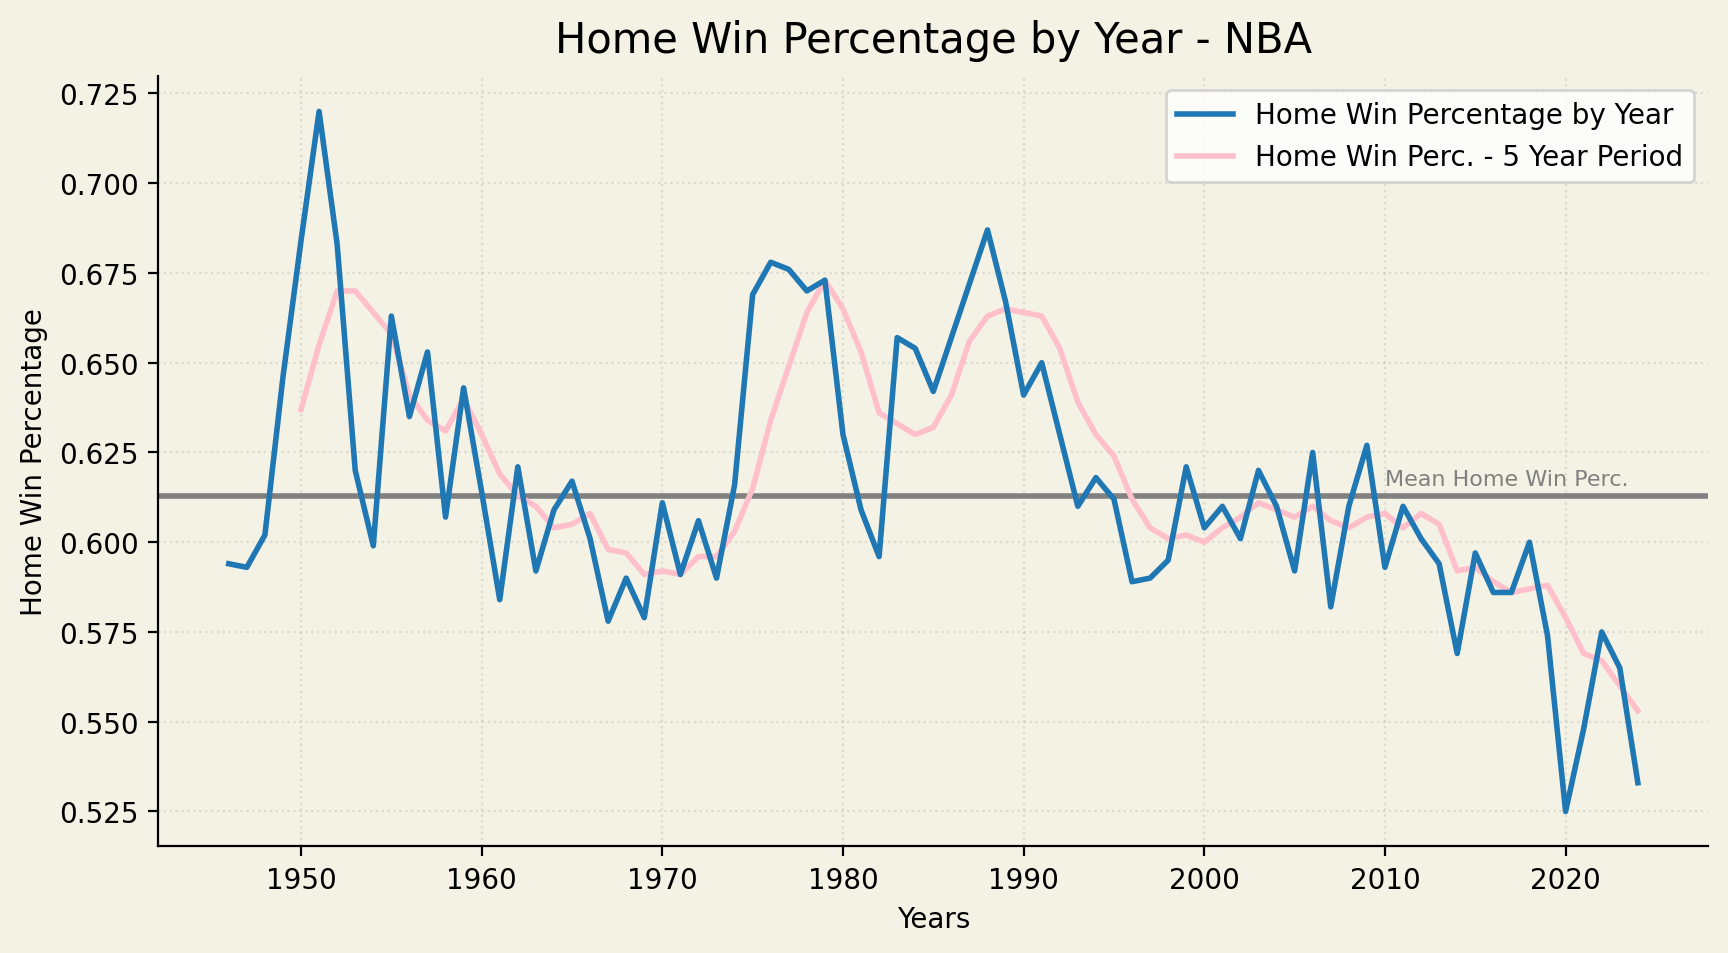

In [66]:
## Creating the canvas and the grid for the visualisation for esthaetical purposes

plt.figure(figsize = (10, 5), dpi = 200, facecolor = '#f4f2e5')

ax = plt.axes()
ax.set_facecolor("#f4f2e5")

ax.grid(True, color = 'grey', ls = ":", alpha = 0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Selecting the labels and the title

ax.set_xlabel("Years")
ax.set_ylabel("Home Win Percentage")

plt.title("Home Win Percentage by Year - NBA", fontsize = 15, y = 1.01)

## Plotting the lines for both Home Wins Percentage per Year, and for five year periods
## (x values, y values, line width, overlapping order, line color, label for the legend)

ax.plot(wins_by_year_df['Year'], wins_by_year_df['HomePerc'], linewidth = 2, zorder = 3, label = "Home Win Percentage by Year")
ax.plot(wins_by_year_df['Year'], rolling_avg['HomePerc'], linewidth = 2, zorder = 2, color = 'pink', label = "Home Win Perc. - 5 Year Period")

## Plotting the horizontal line with the mean win percentage throughout the NBA history

ax.axhline(home_wins_perc, linewidth = 2, zorder = 1, color = "grey")
ax.text(2010, home_wins_perc + 0.003, "Mean Home Win Perc.", zorder = 1, color = "grey", fontsize = 8)

## Showing the legend

ax.legend()

### RENAMING THE TEAMS
source = "https://en.wikipedia.org/wiki/List_of_relocated_National_Basketball_Association_teams"

In [67]:
## Creating a looping function which will change the teams name to the one they use today

def check_team(team_name):
    if team_name == "Tri-Cities Blackhawks" or team_name == "Milwaukee Hawks" or team_name == "St. Louis Hawks":
        new_team_name = "Atlanta Hawks"
        return new_team_name
    elif team_name == "Fort Wayne Pistons":
        new_team_name = "Detroit Pistons"
        return new_team_name
    elif team_name == "Rochester Royals" or team_name == "Cincinnati Royals" or team_name == "Kansas City-Omaha Kings" or team_name == "Kansas City Kings":
        new_team_name = "Sacramento Kings"
        return new_team_name
    elif team_name == "Minneapolis Lakers":
        new_team_name = "Los Angeles Lakers"
        return new_team_name
    elif team_name == "Philadelphia Warriors" or team_name == "San Francisco Warriors":
        new_team_name = "Golden State Warriors"
        return new_team_name
    elif team_name == "Chicago Packers" or team_name == "Chicago Zephyrs" or team_name == "Baltimore Bullets" or team_name == "Capital Bullets" or team_name == "Washington Bullets":
        new_team_name = "Washington Wizards"
        return new_team_name
    elif team_name == "Syracuse Nationals":
        new_team_name = "Philadelphia 76ers"
        return new_team_name
    elif team_name == "San Diego Rockets":
        new_team_name = "Houston Rockets"
        return new_team_name
    elif team_name == "Buffalo Braves" or team_name == "San Diego Clippers":
        new_team_name = "Los Angeles Clippers"
        return new_team_name
    elif team_name == "Vancouver Grizzlies":
        new_team_name = "Memphis Grizzlies"
        return new_team_name
    elif team_name == "New Orleans Jazz":
        new_team_name = "Utah Jazz"
        return new_team_name
    elif team_name == "New Orleans Hornets" or team_name == "New Orleans/Oklahoma City Hornets":
        new_team_name = "New Orleans Pelicans"
        return new_team_name
    elif team_name == "Seattle SuperSonics":
        new_team_name = "Oklahoma City Thunder"
        return new_team_name
    elif team_name == "New York Nets" or team_name == "New Jersey Nets":
        new_team_name = "Brooklyn Nets"
        return new_team_name
    elif team_name == "Charlotte Bobcats":
        new_team_name = "Charlotte Hornets"
        return new_team_name
    else:
        return team_name

In [68]:
## Check Home Teams and change the names if necessary

for i, row in df.iterrows():
    home_team = row['Home'] 
    checked = check_team(home_team)
    df.at[i, 'Home'] = checked
    
## Check Away Teams and change the names if necessary

for i, row in df.iterrows():
    away_team = row['Visitor']
    checked = check_team(away_team)
    df.at[i, 'Visitor'] = checked

### CREATING THE ELO CALCULATION FORMULA
source: "https://www.omnicalculator.com/sports/elo"

In [69]:
def elo_change(home_score, visitor_score, home_rating, visitor_rating):
        
    ## K-Factor is the development coefficient, it is predetermined and in most of the cases where the outcome is 0 or 1, it is 20
    k_factor = 20
    
    if home_score > visitor_score:
        
        ## If the home team wins, the score is 1, if the away team wins, the score is 0. There are no draws in basketball
        
        score = 1
        difference = visitor_rating - home_rating
        diff_ratio = difference / 400
        power = pow(10, diff_ratio) + 1      
        expected_score = round(1 / power, 5)
        elo_change = round(k_factor * (score - expected_score), 1)
        
        ## Creating the new ratings
        
        new_home_rating = home_rating + elo_change
        new_visitor_rating = visitor_rating - elo_change
        
        return home_rating, visitor_rating, new_home_rating, new_visitor_rating, expected_score
        
    else:
        
        score = 0
        difference = visitor_rating - home_rating
        diff_ratio = difference / 400
        power = pow(10, diff_ratio) + 1      
        expected_score = round(1 / power, 4)
        elo_change = round(k_factor * (score - expected_score), 1)
        
        new_home_rating = home_rating + elo_change
        new_visitor_rating = visitor_rating - elo_change
        
        return home_rating, visitor_rating, new_home_rating, new_visitor_rating, expected_score

### FILLING THE DATAFRAME WITH ELO DATA

In [70]:
## Adding empty columns to the dataframe, which will later be filled with the elo data

df['HomeRtg'] = None
df['VisRtg'] = None
df['HomeProb'] = None
df['VisProb'] = None
df['HomeNewRtg'] = None
df['VisNewRtg'] = None

## Making a list of unique teams and assigning each one with elo rating of 1200 for start

unique_teams = pd.unique(df[['Home', 'Visitor']].values.ravel('K')).tolist()
active_elo = [1200.0] * len(unique_teams)

## Iterrating through the dataframe to add the elo stats

for i, row in df.iterrows():
    home_team = row['Home']
    home_pts = row['HomePts']
    visitor_team = row['Visitor']
    vis_pts = row['VisPts']
    
    ## Changing the df data for HomeRtg and the VisRtg to the value in the active_elo list
    
    for team in unique_teams:
        if team == home_team:
            home_team_index = unique_teams.index(team)
            home_team_active_elo = active_elo[home_team_index]
            df.at[i, 'HomeRtg'] = home_team_active_elo
        elif team == visitor_team:
            visitor_team_index = unique_teams.index(team)
            visitor_team_active_elo = active_elo[visitor_team_index]
            df.at[i, 'VisRtg'] = visitor_team_active_elo
            
    ## Using the elo_change function to calculate the elo changes
            
    elo_math = elo_change(home_pts, vis_pts, home_team_active_elo, visitor_team_active_elo)
    
    ## Updating dataframe values with the new ones for the probability, and the newelo based on the result
    
    df.at[i, 'HomeNewRtg'] = elo_math[2]
    df.at[i, 'VisNewRtg'] = elo_math[3]
    df.at[i, 'HomeProb'] = elo_math[4]
    df.at[i, 'VisProb'] = 1 - elo_math[4]
    
    ## Updating the active_elo list depending on the result
    
    active_elo[home_team_index] = elo_math[2]
    active_elo[visitor_team_index] = elo_math[3]

### DATAFRAME WITH THE HISTORICAL ELO RATING DATA

In [71]:
## Creating a copy of the dataframe, in case of losing the data

df_copy = df

df

,Date,Home,HomePts,Visitor,VisPts,Arena,Attend.,Notes,Start (ET),HomeRtg,VisRtg,HomeProb,VisProb,HomeNewRtg,VisNewRtg
0,"Fri, Nov 1, 1946",Toronto Huskies,66.0,New York Knicks,68.0,Maple Leaf Gardens,NaN,NaN,NaN,1200.0,1200.0,0.5,0.5,1190.0,1210.0
1,"Sat, Nov 2, 1946",Chicago Stags,63.0,New York Knicks,47.0,Chicago Stadium,NaN,NaN,NaN,1200.0,1210.0,0.48561,0.51439,1210.3,1199.7
2,"Sat, Nov 2, 1946",St. Louis Bombers,56.0,Pittsburgh Ironmen,51.0,St. Louis Arena,NaN,NaN,NaN,1200.0,1200.0,0.5,0.5,1210.0,1190.0
3,"Sat, Nov 2, 1946",Detroit Falcons,33.0,Washington Capitols,50.0,Detroit Olympia,NaN,NaN,NaN,1200.0,1200.0,0.5,0.5,1190.0,1210.0
4,"Sat, Nov 2, 1946",Providence Steamrollers,59.0,Boston Celtics,53.0,Rhode Island Auditorium,NaN,NaN,NaN,1200.0,1200.0,0.5,0.5,1210.0,1190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70529,"Thu, Jun 6, 2024",Boston Celtics,107.0,Dallas Mavericks,89.0,TD Garden,19156.0,NaN,8:30p,1469.1,1390.0,0.61191,0.38809,1476.9,1382.2
70530,"Sun, Jun 9, 2024",Boston Celtics,105.0,Dallas Mavericks,98.0,TD Garden,19156.0,NaN,8:00p,1476.9,1382.2,0.63301,0.36699,1484.2,1374.9
70531,"Wed, Jun 12, 2024",Dallas Mavericks,99.0,Boston Celtics,106.0,American Airlines Center,20311.0,NaN,8:30p,1374.9,1484.2,0.3477,0.6523,1367.9,1491.2
70532,"Fri, Jun 14, 2024",Dallas Mavericks,122.0,Boston Celtics,84.0,American Airlines Center,20277.0,NaN,8:30p,1367.9,1491.2,0.32965,0.67035,1381.3,1477.8


### CREATING A DATAFRAME WITH THE CURRENT ELO RATINGS

In [72]:
df_current_data = pd.DataFrame(list(zip(unique_teams, active_elo)), columns = ['Team', 'Elo'])

df_current_data = df_current_data.sort_values(by = "Elo", ascending = False).reset_index(drop = True)

## Removing the defunct teams
## source "https://en.wikipedia.org/wiki/List_of_defunct_National_Basketball_Association_teams"

def_teams = ['Anderson Packers', 'Baltimore Bullets', 'Chicago Stags', 'Cleveland Rebels', 'Detroit Falcons',
            'Indianapolis Jets', 'Indianapolis Olympians', 'Pittsburgh Ironmen', 'Providence Steamrollers',
            'Sheboygan Red Skins', 'St. Louis Bombers', 'Toronto Huskies', 'Washington Capitols', 'Waterloo Hawks']

df_current_data = df_current_data[~df_current_data['Team'].isin(def_teams)].reset_index(drop = True)

df_current_data

,Team,Elo
0,Boston Celtics,1485.1
1,Denver Nuggets,1386.4
2,Dallas Mavericks,1374.0
3,Oklahoma City Thunder,1360.5
4,Minnesota Timberwolves,1356.2
5,New York Knicks,1313.8
6,Los Angeles Lakers,1307.7
7,Phoenix Suns,1295.8
8,Golden State Warriors,1293.9
9,Indiana Pacers,1289.3


### BOSTON CELTICS HISTORICAL ELO

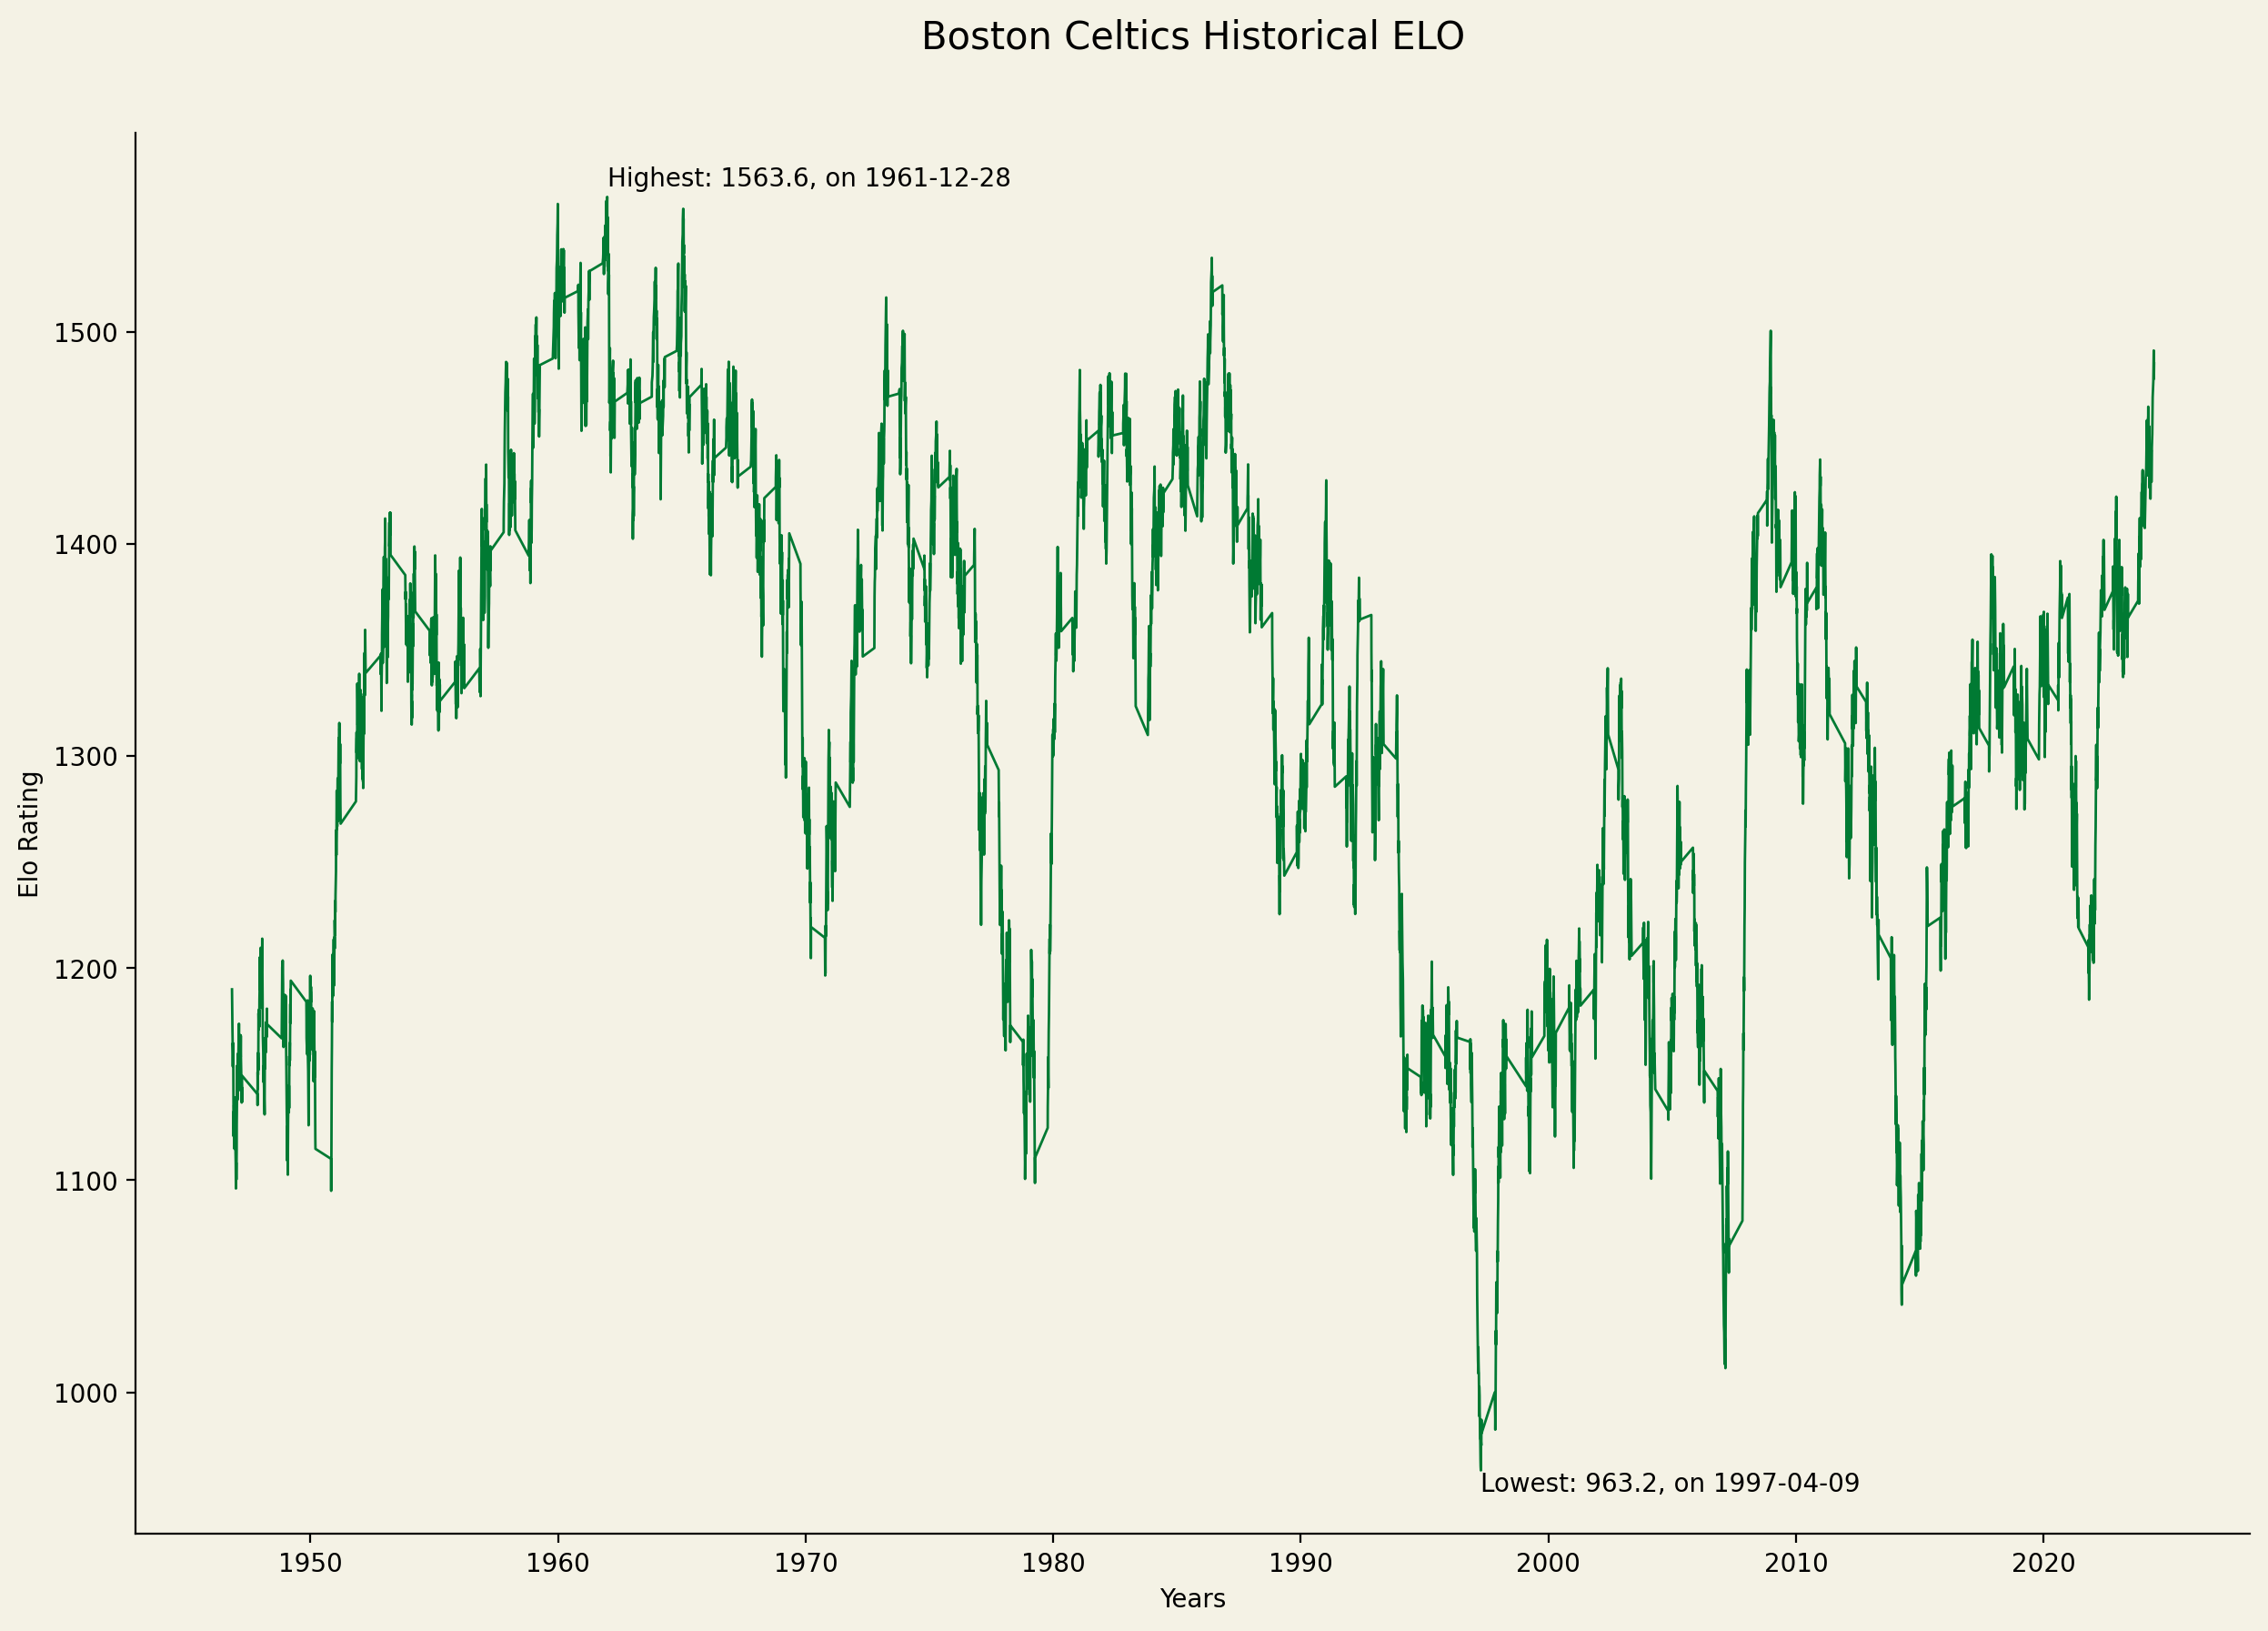

In [73]:
## Creating the Dataframe just with the Boston Celtics games

bos_elo_df = df.loc[(df['Home'] == 'Boston Celtics') | (df['Visitor'] == 'Boston Celtics')]
        
## Extracting the data from the bos_elo_df dataset to get the game and elo details for every Celtics game    

game_dates, opponent, result, bos_elo = [], [], [], []

for i, row in bos_elo_df.iterrows():
    if row['Home'] == 'Boston Celtics':
        game_dates.append(row['Date'])
        opponent.append(row['Visitor'])
        if row['HomePts'] > row['VisPts']:
            result.append(f"Win v. {int(row['HomePts'])}-{int(row['VisPts'])}")
        else:
            result.append(f"Loss v. {int(row['HomePts'])}-{int(row['VisPts'])}")
        bos_elo.append(row['HomeNewRtg'])
    elif row['Visitor'] == 'Boston Celtics':
        game_dates.append(row['Date'])
        opponent.append(row['Home'])
        if row['VisPts'] > row['HomePts']:
            result.append(f"Win @ {int(row['HomePts'])}-{int(row['VisPts'])}")
        else:
            result.append(f"Loss @ {int(row['HomePts'])}-{int(row['VisPts'])}")
        bos_elo.append(row['VisNewRtg'])
        
bos_elo_trend = pd.DataFrame(list(zip(game_dates, opponent, result, bos_elo)), columns = ['Date', 'Opp.', 'Result', 'Elo'])

## Getting the minimum and the maximum elo rating in the team's history

bos_elo_max = bos_elo_trend.loc[bos_elo_trend['Elo'] == bos_elo_trend['Elo'].max()].reset_index()
bos_elo_min = bos_elo_trend.loc[bos_elo_trend['Elo'] == bos_elo_trend['Elo'].min()].reset_index()

bos_elo_trend['Date'] = pd.to_datetime(bos_elo_trend['Date'])
bos_elo_max['Date'] = pd.to_datetime(bos_elo_max['Date'])
bos_elo_min['Date'] = pd.to_datetime(bos_elo_min['Date'])

## Plotting the Boston ELO

plt.figure(figsize=(15, 10), dpi=200, facecolor='#f4f2e5')

ax = plt.axes()
ax.set_facecolor('#f4f2e5')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Years")
ax.set_ylabel("Elo Rating")

plt.title("Boston Celtics Historical ELO", fontsize=15, y=1.05)

ax.plot(bos_elo_trend['Date'], bos_elo_trend['Elo'], linewidth=1, zorder=2, color='#007A33')

max_elo_value = bos_elo_max['Elo'].iloc[0]
min_elo_value = bos_elo_min['Elo'].iloc[0]

max_formatted_date = bos_elo_max['Date'].iloc[0].strftime('%Y-%m-%d')
min_formatted_date = bos_elo_min['Date'].iloc[0].strftime('%Y-%m-%d')

ax.text(bos_elo_max['Date'], max_elo_value + 5, f"Highest: {round(max_elo_value, 1)}, on {max_formatted_date}", fontsize=10)

ax.text(bos_elo_min['Date'], min_elo_value - 10, f"Lowest: {round(min_elo_value, 1)}, on {min_formatted_date}", fontsize=10)

plt.show()

### CHICAGO BULLS

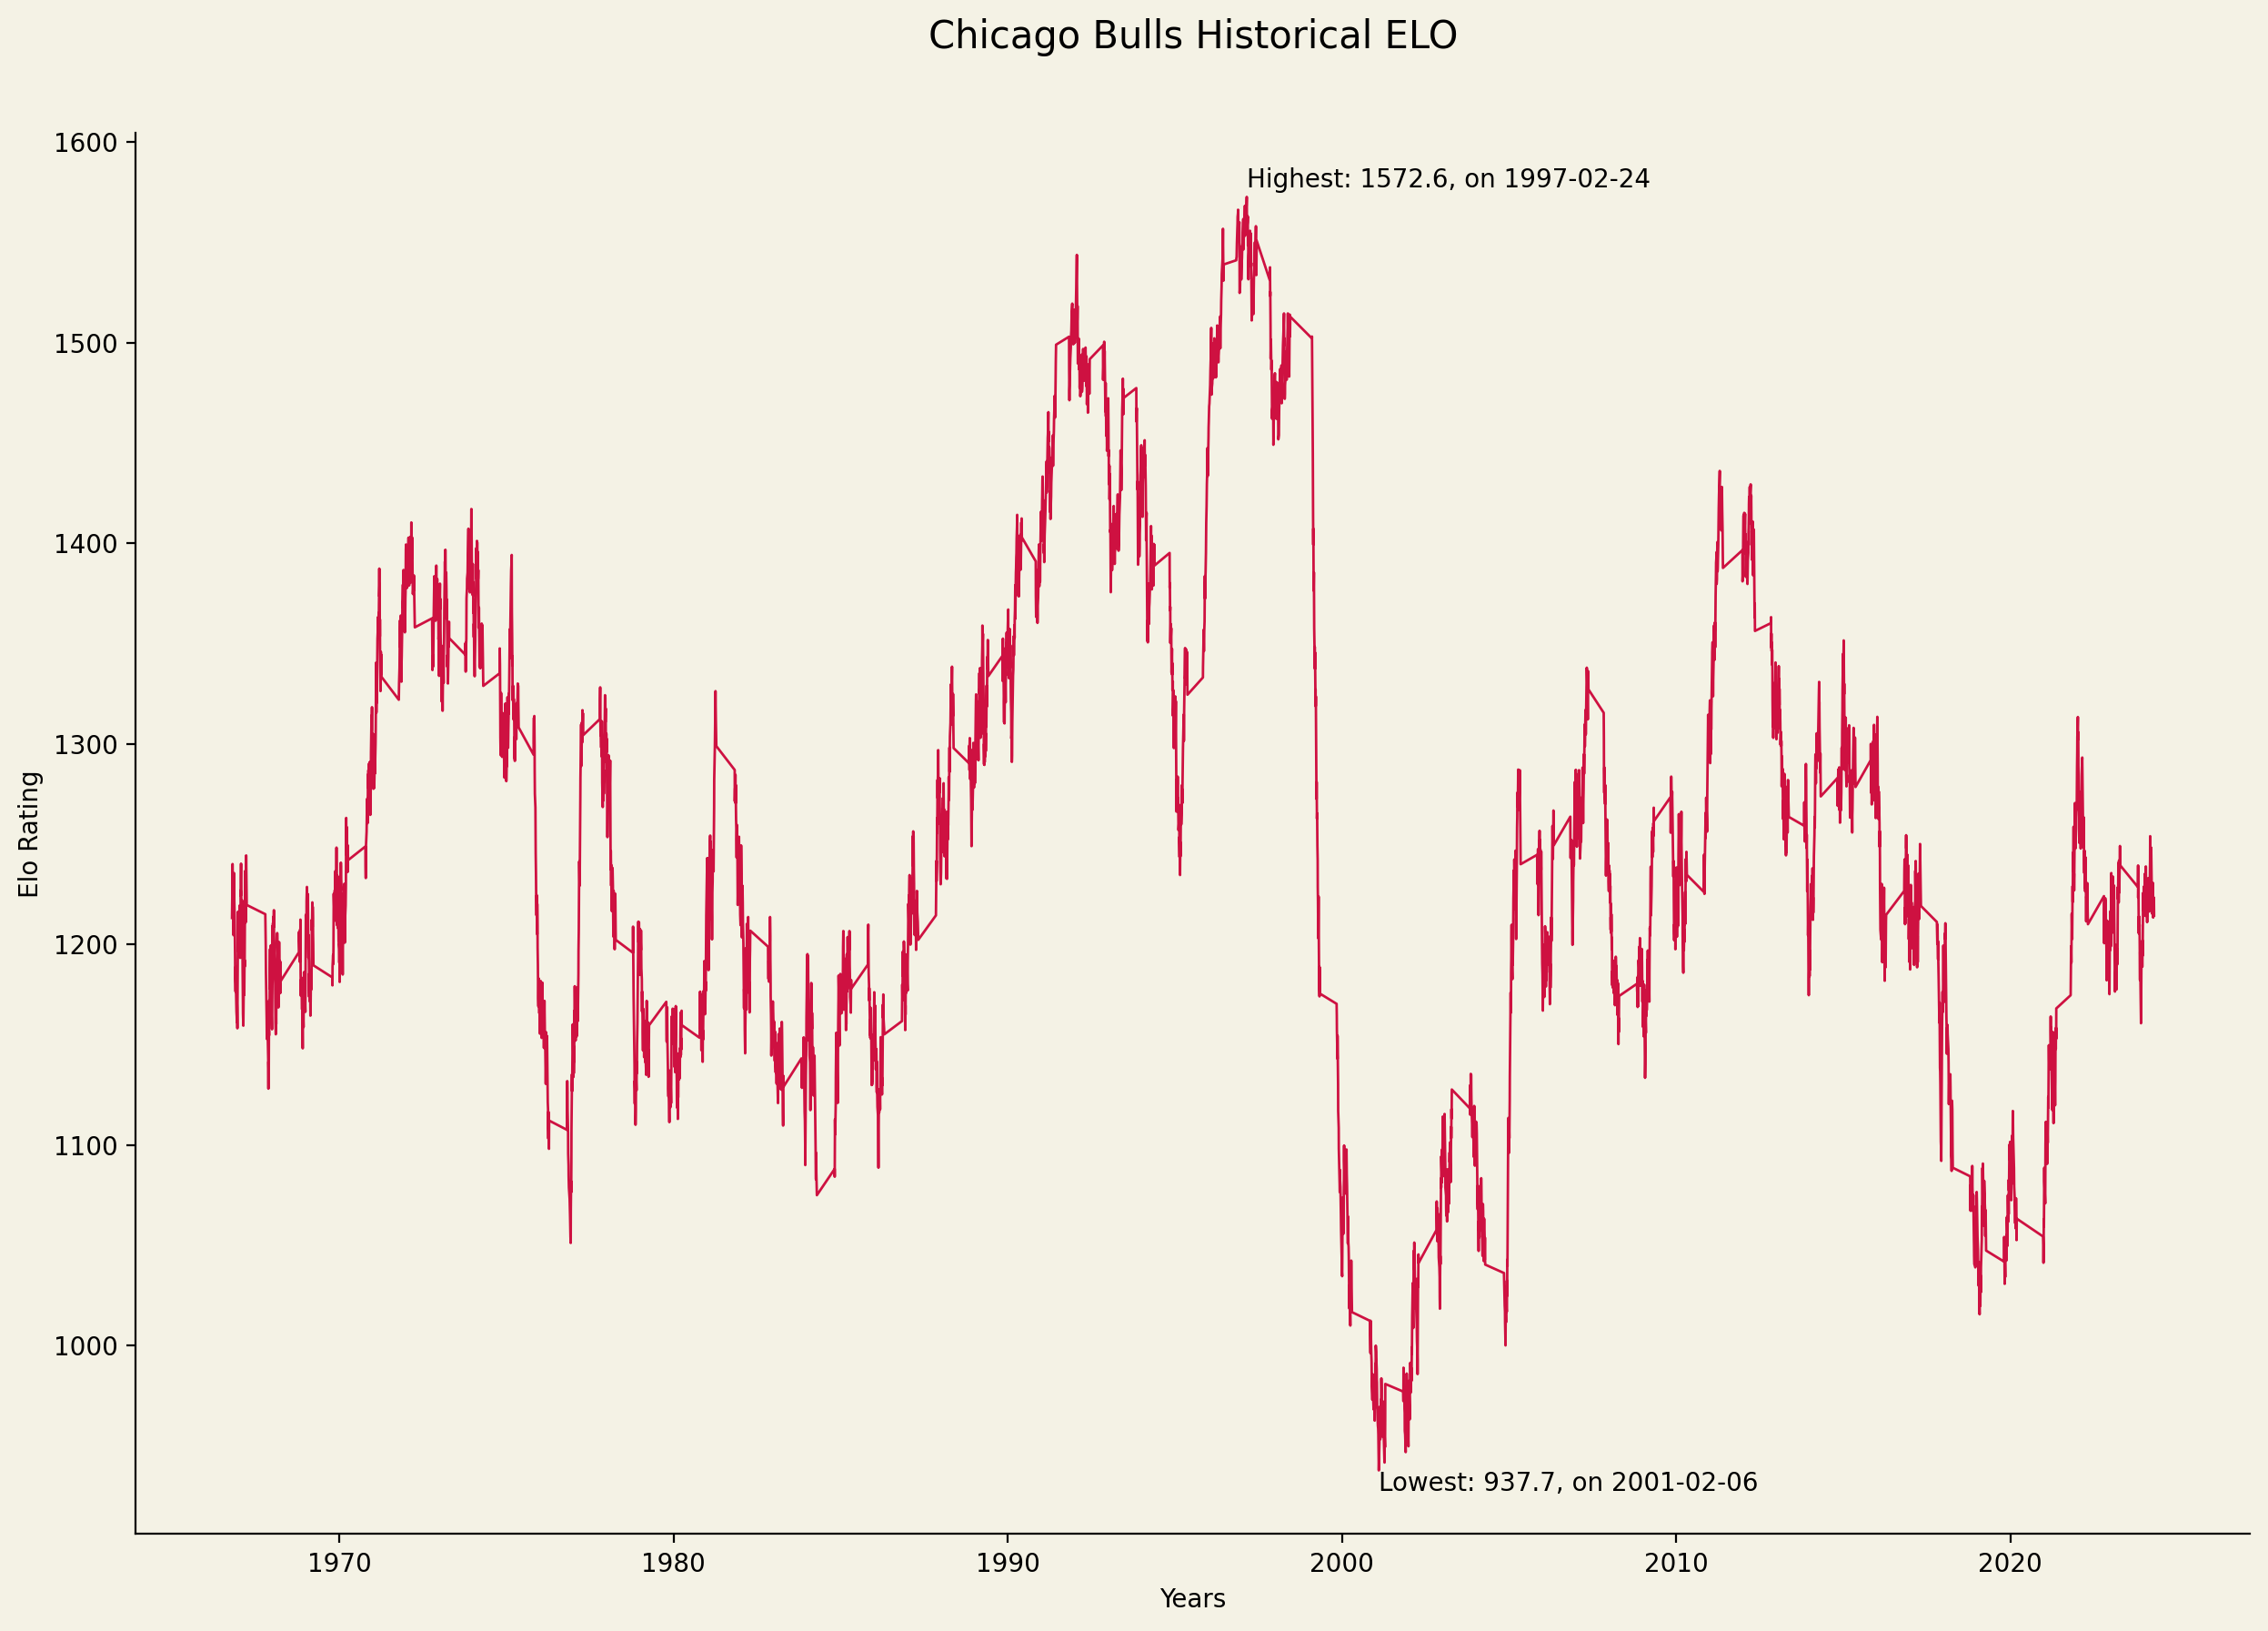

In [74]:
## Doing the same, but for the Chicago Bulls

chi_elo_df = df.loc[(df['Home'] == 'Chicago Bulls') | (df['Visitor'] == 'Chicago Bulls')]
        
game_dates, opponent, result, chi_elo = [], [], [], []

for i, row in chi_elo_df.iterrows():
    if row['Home'] == 'Chicago Bulls':
        game_dates.append(row['Date'])
        opponent.append(row['Visitor'])
        if row['HomePts'] > row['VisPts']:
            result.append(f"Win v. {int(row['HomePts'])}-{int(row['VisPts'])}")
        else:
            result.append(f"Loss v. {int(row['HomePts'])}-{int(row['VisPts'])}")
        chi_elo.append(row['HomeNewRtg'])
    elif row['Visitor'] == 'Chicago Bulls':
        game_dates.append(row['Date'])
        opponent.append(row['Home'])
        if row['VisPts'] > row['HomePts']:
            result.append(f"Win @ {int(row['HomePts'])}-{int(row['VisPts'])}")
        else:
            result.append(f"Loss @ {int(row['HomePts'])}-{int(row['VisPts'])}")
        chi_elo.append(row['VisNewRtg'])
        
chi_elo_trend = pd.DataFrame(list(zip(game_dates, opponent, result, chi_elo)), columns = ['Date', 'Opp.', 'Result', 'Elo'])

## Getting the minimum and the maximum elo rating in the team's history

chi_elo_max = chi_elo_trend.loc[chi_elo_trend['Elo'] == chi_elo_trend['Elo'].max()].reset_index()
chi_elo_min = chi_elo_trend.loc[chi_elo_trend['Elo'] == chi_elo_trend['Elo'].min()].reset_index()

chi_elo_trend['Date'] = pd.to_datetime(chi_elo_trend['Date'])
chi_elo_max['Date'] = pd.to_datetime(chi_elo_max['Date'])
chi_elo_min['Date'] = pd.to_datetime(chi_elo_min['Date'])

## Plotting the Chicago ELO

plt.figure(figsize=(15, 10), dpi=200, facecolor='#f4f2e5')

ax = plt.axes()
ax.set_facecolor('#f4f2e5')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Years")
ax.set_ylabel("Elo Rating")

plt.title("Chicago Bulls Historical ELO", fontsize=15, y=1.05)

ax.plot(chi_elo_trend['Date'], chi_elo_trend['Elo'], linewidth=1, zorder=2, color='#CE1141')

max_elo_value = chi_elo_max['Elo'].iloc[0]
min_elo_value = chi_elo_min['Elo'].iloc[0]

max_formatted_date = chi_elo_max['Date'].iloc[0].strftime('%Y-%m-%d')
min_formatted_date = chi_elo_min['Date'].iloc[0].strftime('%Y-%m-%d')

ax.text(chi_elo_max['Date'], max_elo_value + 5, f"Highest: {round(max_elo_value, 1)}, on {max_formatted_date}", fontsize=10)

ax.text(chi_elo_min['Date'], min_elo_value - 10, f"Lowest: {round(min_elo_value, 1)}, on {min_formatted_date}", fontsize=10)

plt.show()

## PERCENTAGE OF WINS BY TEAMS WITH HIGHER ELO

In [75]:
## What is the percentage of wins for the teams with higher ELO ratings

total_games = 0
guessed = 0

for i, row in df.iterrows():
    
    ## Exclude the possibility of a draw
    
    if row['HomeProb'] != row['VisProb']:
        total_games = total_games + 1
        if row['HomePts'] > row['VisPts']:
            if row['HomeProb'] > row['VisProb']:
                guessed = guessed + 1
        elif row['HomePts'] < row['VisPts']:
            if row['HomeProb'] < row['VisProb']:
                guessed = guessed + 1
                
total_guessing_perc = round(guessed / total_games, 3)

print(f"Total guessing percentage based on the team with the bigger ELO: {total_guessing_perc}")

Total guessing percentage based on the team with the bigger ELO: 0.638


## BIGGEST ELO DIFFERENCE IN HISTORY

In [76]:
## Getting the maximum ELO difference
df['EloDiff'] = abs(df['HomeRtg'] - df['VisRtg'])
max_elo_diff = df['EloDiff'].max()

max_df_game = df.loc[df['EloDiff'] == max_elo_diff]

print(f"Biggest ELO difference between two teams occured on {max_df_game['Date'].iloc[0]}")
print(f"In a game between {max_df_game['Home'].iloc[0]} - {round(max_df_game['HomeRtg'].iloc[0], 1)} and {max_df_game['Visitor'].iloc[0]} - {round(max_df_game['VisRtg'].iloc[0], 1)}")
print(f"The difference was {max_df_game['EloDiff'].iloc[0]}")

if max_df_game['HomePts'].iloc[0] > max_df_game['VisPts'].iloc[0]:
    print(f"{max_df_game['Home'].iloc[0]} won the game {int(max_df_game['HomePts'].iloc[0])}-{int(max_df_game['VisPts'].iloc[0])}")
else:
    print(f"{max_df_game['Visitor'].iloc[0]} won the game {int(max_df_game['VisPts'].iloc[0])}-{int(max_df_game['HomePts'].iloc[0])}")

Biggest ELO difference between two teams occured on Sun, Mar 27, 2016
In a game between Golden State Warriors - 1570.7 and Philadelphia 76ers - 906.0
The difference was 664.7
Golden State Warriors won the game 117-105


## BIGGEST UPSETS EVER

In [77]:
## Now that we have the Elo Difference between teams created together, lets sort the Dataframe to check the biggest differences in Elo

df_sorted = df.sort_values(by = 'EloDiff', ascending = False)

## Now lets find all the games where the team with lower Elo won the game

df_upsets = df_sorted.loc[((df_sorted['HomePts'] > df_sorted['VisPts']) & (df_sorted['HomeRtg'] < df_sorted['VisRtg'])) | ((df_sorted['HomePts'] < df_sorted['VisPts']) & (df_sorted['HomeRtg'] > df_sorted['VisRtg']))]

## List of Top 10 biggest upsets based on Elo difference

df_upsets.head(10)

,Date,Home,HomePts,Visitor,VisPts,Arena,Attend.,Notes,Start (ET),HomeRtg,VisRtg,HomeProb,VisProb,HomeNewRtg,VisNewRtg,EloDiff
59938,"Sun, Mar 6, 2016",Los Angeles Lakers,112.0,Golden State Warriors,95.0,STAPLES Center,18997,NaN,3:30p,987.4,1581.6,0.03166,0.96834,1006.8,1562.2,594.2
36412,"Fri, Oct 31, 1997",Boston Celtics,92.0,Chicago Bulls,85.0,FleetCenter,18624,NaN,NaN,980.7,1550.7,0.03622,0.96378,1000.0,1531.4,570.0
37819,"Wed, Feb 24, 1999",Denver Nuggets,97.0,Utah Jazz,87.0,McNichols Sports Arena,10925,NaN,NaN,950.1,1507.8,0.03878,0.96122,969.3,1488.6,557.7
38074,"Sat, Mar 27, 1999",Los Angeles Clippers,103.0,Utah Jazz,77.0,Arrowhead Pond,14293,"at Anaheim, CA",NaN,925.5,1471.1,0.04146,0.95854,944.7,1451.9,545.6
46388,"Sat, Dec 10, 2005",Atlanta Hawks,94.0,San Antonio Spurs,84.0,Philips Arena,16678,NaN,7:00p,923.6,1467.7,0.0418,0.9582,942.8,1448.5,544.1
41500,"Sat, Jan 12, 2002",Chicago Bulls,106.0,Los Angeles Lakers,104.0,United Center,23147,NaN,8:30p,963.2,1480.7,0.04839,0.95161,982.2,1461.7,517.5
20087,"Sat, Jan 15, 1983",Cleveland Cavaliers,90.0,Boston Celtics,86.0,Coliseum at Richfield,7548.0,NaN,NaN,956.6,1459.4,0.05243,0.94757,975.6,1440.4,502.8
25066,"Wed, Jan 13, 1988",Los Angeles Clippers,110.0,Los Angeles Lakers,109.0,Los Angeles Memorial Sports Arena,14906.0,NaN,NaN,984.3,1485.0,0.05304,0.94696,1003.2,1466.1,500.7
26875,"Sat, Nov 11, 1989",Miami Heat,88.0,Detroit Pistons,84.0,Miami Arena,15008,NaN,NaN,1014.9,1514.8,0.05327,0.94673,1033.8,1495.9,499.9
60402,"Fri, Nov 4, 2016",Los Angeles Lakers,117.0,Golden State Warriors,97.0,STAPLES Center,18997,NaN,10:30p,1024.7,1517.9,0.05525,0.94475,1043.6,1499.0,493.2


In [78]:
## Checking what is the ELO difference in the range of the average home win percentage (0,614)

elo_list = []

for i, row in df.iterrows():
    if round(row['HomeProb'], 3) == 0.614:
        elo_list.append(row['HomeRtg'])
    elif round(row['VisProb'], 3) == 0.614:
        elo_list.append(row['VisRtg'])
        
mean_elo = round(np.mean(elo_list), 3)
median_elo = round(np.median(elo_list), 3)
        
print(f"Mean Elo for those with the average home win percentage is {mean_elo}")
print(f"Median Elo for those with the average home win percentage is {median_elo}")

home_advantage = round((mean_elo + median_elo) / 2) - 1200

print(f"To not complicate further, home advantage will in the future be in between the mean and the median, which is {home_advantage}")

Mean Elo for those with the average home win percentage is 1283.528
Median Elo for those with the average home win percentage is 1283.6
To not complicate further, home advantage will in the future be in between the mean and the median, which is 84


In [79]:
## Adding the odds to the dataframe

df['HomeAdvElo'] = df['HomeRtg'] + home_advantage

df['BetWinProbHome'] = 1 / (pow(10, (df['VisRtg'] - df['HomeAdvElo']) / 400) + 1)

df['BetWinProbVis'] = 1 - df['BetWinProbHome']

df['DecOddHome'] = 1 / df['BetWinProbHome']
df['DeccOddVis'] = 1 / df['BetWinProbVis']

## FINAL DATAFRAME VERSION

In [80]:
df

,Date,Home,HomePts,Visitor,VisPts,Arena,Attend.,Notes,Start (ET),HomeRtg,...,HomeProb,VisProb,HomeNewRtg,VisNewRtg,EloDiff,HomeAdvElo,BetWinProbHome,BetWinProbVis,DecOddHome,DeccOddVis
0,"Fri, Nov 1, 1946",Toronto Huskies,66.0,New York Knicks,68.0,Maple Leaf Gardens,NaN,NaN,NaN,1200.0,...,0.5,0.5,1190.0,1210.0,0.0,1284.0,0.618584,0.381416,1.616595,2.62181
1,"Sat, Nov 2, 1946",Chicago Stags,63.0,New York Knicks,47.0,Chicago Stadium,NaN,NaN,NaN,1200.0,...,0.48561,0.51439,1210.3,1199.7,10.0,1284.0,0.604913,0.395087,1.653131,2.531087
2,"Sat, Nov 2, 1946",St. Louis Bombers,56.0,Pittsburgh Ironmen,51.0,St. Louis Arena,NaN,NaN,NaN,1200.0,...,0.5,0.5,1210.0,1190.0,0.0,1284.0,0.618584,0.381416,1.616595,2.62181
3,"Sat, Nov 2, 1946",Detroit Falcons,33.0,Washington Capitols,50.0,Detroit Olympia,NaN,NaN,NaN,1200.0,...,0.5,0.5,1190.0,1210.0,0.0,1284.0,0.618584,0.381416,1.616595,2.62181
4,"Sat, Nov 2, 1946",Providence Steamrollers,59.0,Boston Celtics,53.0,Rhode Island Auditorium,NaN,NaN,NaN,1200.0,...,0.5,0.5,1210.0,1190.0,0.0,1284.0,0.618584,0.381416,1.616595,2.62181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70529,"Thu, Jun 6, 2024",Boston Celtics,107.0,Dallas Mavericks,89.0,TD Garden,19156.0,NaN,8:30p,1469.1,...,0.61191,0.38809,1476.9,1382.2,79.1,1553.1,0.718873,0.281127,1.391066,3.557113
70530,"Sun, Jun 9, 2024",Boston Celtics,105.0,Dallas Mavericks,98.0,TD Garden,19156.0,NaN,8:00p,1476.9,...,0.63301,0.36699,1484.2,1374.9,94.7,1560.9,0.73666,0.26334,1.357479,3.797371
70531,"Wed, Jun 12, 2024",Dallas Mavericks,99.0,Boston Celtics,106.0,American Airlines Center,20311.0,NaN,8:30p,1374.9,...,0.3477,0.6523,1367.9,1491.2,109.3,1458.9,0.463655,0.536345,2.156778,1.86447
70532,"Fri, Jun 14, 2024",Dallas Mavericks,122.0,Boston Celtics,84.0,American Airlines Center,20277.0,NaN,8:30p,1367.9,...,0.32965,0.67035,1381.3,1477.8,123.3,1451.9,0.443683,0.556317,2.253863,1.797535


## PROJECTING ODDS PROGRAM

In [81]:
def odds_program():
    home_team = input("Input the Home Team: ")
    away_team = input("Input the Away Team: ")
    
    home_team_index = df_current_data.index[df_current_data['Team'] == home_team]
    home_team_elo = df_current_data.loc[home_team_index, 'Elo'] + home_advantage
    
    away_team_index = df_current_data.index[df_current_data['Team'] == away_team]
    away_team_elo = df_current_data.loc[away_team_index, 'Elo']
    
    difference = away_team_elo.iloc[0] - home_team_elo.iloc[0]
    ratio = difference / 400
    power = pow(10, ratio) + 1
    expected = 1 / power
    
    print(f"Percentage of {home_team} winning is {round(expected * 100, 2)}%")
    print(f"Percentage of {away_team} winning is {round((1 - expected) * 100, 2)}%")
    print("")
    print(f"The decimal odds for {home_team} winning are {round(1 / expected, 2)}")
    print(f"The decimal odds for {away_team} winning are {round(1 / (1 - expected), 2)}")

In [84]:
df_current_data

,Team,Elo
0,Boston Celtics,1485.1
1,Denver Nuggets,1386.4
2,Dallas Mavericks,1374.0
3,Oklahoma City Thunder,1360.5
4,Minnesota Timberwolves,1356.2
5,New York Knicks,1313.8
6,Los Angeles Lakers,1307.7
7,Phoenix Suns,1295.8
8,Golden State Warriors,1293.9
9,Indiana Pacers,1289.3


In [86]:
odds_program()

Input the Home Team: Detroit Pistons
Input the Away Team: Boston Celtics
Percentage of Detroit Pistons winning is 7.65%
Percentage of Boston Celtics winning is 92.35%

The decimal odds for Detroit Pistons winning are 13.06
The decimal odds for Boston Celtics winning are 1.08
